# Buffered Uncertainty-Aware Voronoi Cells for Probabilistic Multi-Robot Collision and Deadlock Avoidance
Author: Adi Amuzig  
E-mail: [adi.amuzig@campus.technion.ac.il](mailto:adi.amuzig@campus.technion.ac.il)

## Introduction

If we consider a single agent that travels autonomously in the environment, even though we design a path that avoids collisions, the agent will still make errors in its motions, if these errors are not considered then collisions may occur. When dealing with an autonomous multi-agent system, the problem becomes exponentially more difficult. Now, each individual path must be planned in such a way that each agent avoids collisions in with the environment and with other agents, yet, as previously stated, collisions may still occur even if the plan does not contain them.

Collisions might cause the agents' subsequent actions to be delayed, damaged, or even make the mission impossible. The problem of autonomous multi-robot collision avoidance is critical for various systems, ranging from a swarm of drones' three-dimensional surroundings to the constrained motions of autonomous cars.

<img src="images\driverless-car-crash.jpg" width="500" align="center"/>

Deadlock is another fenomonn that must be avoided. A scenario in which two or more agents have stopped moving because they are obstructing each other's path to their goals. When viewing deadlock through the lens of an autonomous multi-agent system, the motions of the agents are dictated by an algorithm, which must contemplate a solution in the case of deadlock. A number of research have been conducted to determine the best technique to address stalemate situations in order to resolve and deal with them as quickly as feasible. Without addressing the risk of deadlock, the agent will be unable to resolve the choice of moving on its own.

<img src="images\deadlock.jpeg" width="500" align="center"/>

The problem we're trying to tackle is how to properly design pathways in a multi-robot system while accounting for the robots' movement faults and avoiding deadlock.


Avoiding collisions and deadlock in an autonumos multi-robot system are problematic for a few key reasons:

1. Examining all robots' motions and trajectories simultaneously.
2. How to quantify location uncertainty. 
3. In what way should you account for the location uncertainty in path planning.
4. How to optimize the path for all agents to the objective.


### Previus solotions

The approach provided in [B-UAVC: Buffered Uncertainty-Aware Voronoi Cells for Probabilistic Multi-Robot Collision Avoidance](https://ieeexplore.ieee.org/document/8901092) was expanded in this work. They began by using voronoi cells to split the area into separate zones adjacent to each of the agents, as shown in figure (a). The cells' edges were then adjusted based on an estimated position uncertainty in the form of a Gaussian distribution, as shown in figure (b). This allowed them to account for the varying sizes of location uncertainty in cell development. Later, they added a buffer to the cells in the form of a safety radius that they want to maintain at all times between the agents, as shown in figure (c). Finally, they incorporated the collision probability buffer based on the agents' position uncertainty, as shown in figure (d). These cells were dubbed buffered uncertainty-aware Voronoi cells (B-UAVC).

<img src="images\BUAVC_figure.png" width="700" align="center"/>

In the case of a one-step controller, they instructed the agents to move at full speed toward a specific objective position on the map, and if that was not possible, to proceed at a slower speed that would still enable the agent to remain in its own cell. This instance can easily result in a deadlock in which two agents are ordered to swap places with one another and reach a point where they can no longer continue ahead, resulting in a deadlock.

They employed a method described in [Fast, On-line Collision Avoidance for Dynamic Vehicles Using Buffered Voronoi Cells](https://ieeexplore.ieee.org/abstract/document/7828016) to overcome this problem. If an agent hits a stalemate, it will begin moving around the perimeter of its own cell until it can continue to move ahead. This solution, while effective in most instances, can nonetheless result in a type of deadlock, as explained in the article itself, in which two agents can move continuously at both sides of an edge and become trapped ther.

I addressed this problem by taking a random step that prevents the stalemate stated above from occurring.

### Evaluation of the solotion

I assigned many agents the job of trading positions during the examination. For example, in the figure below, the red and blue agents, as well as the green and cyan, are predicted to swap positions, with the U-BVC in black. I investigated the situation of four, six, and eight agents shifting places. To acquire an average ,I ran each setting 50 times with the same initial conditions.

<img src="images\initial locations and uabvc.png" width="500" align="center"/>


## Domain

My chosen domain is Multi-Agent Goal Orianted (MAGO), which was designed specifically for this project.
The agents in MAGO lack sensory capabilities. The map is an open area with a predetermined number of agents. The domain can theoretically support a greater number of agents, however it currently only supports 3-8 agents at a time.

The dinamic is a one-step controller in this space. That is, each timestep represents a movement in the form of the agent's speed and direction on a 2D map without accelorations. Our domain is critical for this project since it represents the test cases for such algorithms as seen in the fugure below from the paper  [B-UAVC: Buffered Uncertainty-Aware Voronoi Cells for Probabilistic Multi-Robot Collision Avoidance](https://ieeexplore.ieee.org/document/8901092). Figure (a) is the initial locations for the agents and in (b) and (c) we can see the progration of the agents to their goal locations.

<img src="images\paper_example.png" width="700" align="center"/>


In [1]:
from src.fstma import *

# seed for experimental reproducibility
import numpy as np
import random 

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

The graphics below depict a simple operation of this environment, with four agents starting in separate areas, the planned path that they have, and the executed path that they received at the conclusion.

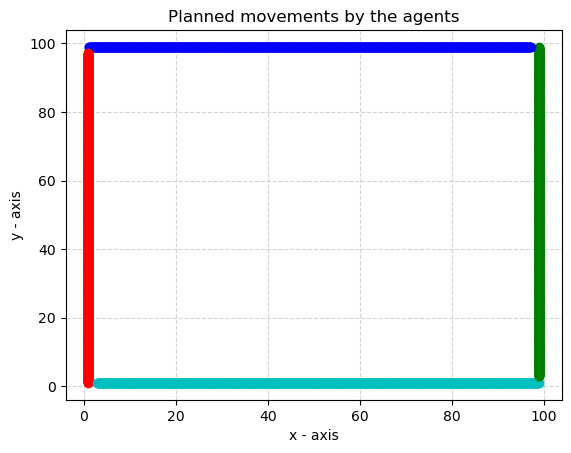

In [2]:
N = 100
speed = 0.1
safty_radius = 1.5
num_of_agents = 4
max_dis = 2
colors = ['r', 'b', 'g', 'c']

init_locations = [[1, 1], [1, N - 1], [N - 1, N - 1], [N - 1, 1]]
goal_locations = [[1, N - 1], [N - 1, N - 1], [N - 1, 1], [1, 1]]

min_distances_plan, KFilters, actions, added_time_tot = genoratePlannedPath(
        init_locations[0: num_of_agents], goal_locations[0: num_of_agents],
        num_of_agents, max_dis, speed, colors[0: num_of_agents], N, safty_radius)

plt.show()

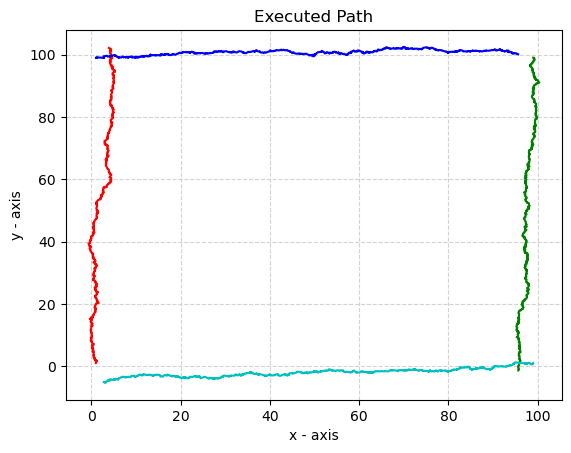

In [3]:
Locations_x = []
Locations_y = []
min_distances_exe = []

for i in range(num_of_agents):
    X = KFilters[i].runSim(actions[i])
    KFilters[i].plotTrajectory(X, colors[i])
    x_location, y_location = fromMat2LocationVal(X, len(X))
    Locations_x.append(x_location)
    Locations_y.append(y_location)

plt.show()

## Model

We model our problem using the tuple $\langle n, S, G, R, P \rangle$ where
    
* $n$ is the number of robots on the two dimensional $R^{2}$ space, where each robot is denoted with $i\in \{1,2,...,n\}$,
* $S = \{s_{i}\in R^{2}\}$ denotes the initial locations of the robots,
* $G = \{g_{i}\in R^{2}\}$ denotes the goal locations of the robots,
* $R = \{r_{i}\in R^{2}\}$ denotes each agent's safety radius, and
* $P = \{P^{j}\} = \{p_{i}^{j}\in R^{2}\}$ denotes the true position of the robots at each time $j$, and is described as a Gaussian distribution with mean $\mu_{i}^{j}$ and covariance $\Sigma_{i}^{j}$ i.e. $p_{i}^{j} = N(\mu_{i}^{j}, \Sigma_{i}^{j})$. 
    

## Solution

I propose a solution in which the agent attempts numerous random steps after it is unable to proceed in a straight line at maximum speed toward the goal location. If it is unable to go forward due to the B-UAVC, it will stop and enable the other agents to progress.

<img src="images\algorithm.png" width="600" align="center"/>

Using this random step, at least one agent will be able to move (depending on how the Voronoi cells operate), producing a change in the creation of the B-UAVC. Because the steps are random, this resolves the deadlock indicated in the prior solutions. The addition of the random step was simple to implement, adding to the appeal of this strategy.

## Key Classes and Functions. 

### Kalman filter

The **PropagateUpdateBelief** function is used to estimate each agent's subsequent belief state based on the provided actions and the agent's movement noise.


    def PropagateUpdateBelief(self, belief_minus_1: belief, u_t: np.matrix, z_t: np.matrix = np.matrix('0,0'), with_observations: bool = False) -> belief:
        """Propogate new belief state acording to Kalman Filter and the previos belief state

        Args:
            belief_minus_1 (belief): Previos belief state
            u_t (np.matrix): Motion model
            z_t (np.matrix, optional): observation model. Defaults to np.matrix('0,0').
            with_observations (bool, optional): does the agent have observation abilities. Defaults to False.

        Returns:
            belief: Next belief state
        """
        mu_bar_t = self.A @ belief_minus_1.mu + self.B @ u_t
        Sigma_bar_t = self.A @ belief_minus_1.Sigma @ self.A.T + self.R

        if with_observations == True:
            K = Sigma_bar_t @ self.C.T @ (self.C @
                                          Sigma_bar_t @ self.C.T + self.Q).I
            mu_t = mu_bar_t + K @ (z_t - self.C @ mu_bar_t)
            Sigma_t = (np.matrix(np.eye(len(K @ self.C))) -
                       K @ self.C) @ Sigma_bar_t

        else:
            mu_t = mu_bar_t
            Sigma_t = Sigma_bar_t

        belief_t = belief(mu_t, Sigma_t)
        return belief_t
        
**SampleMotionModel** is another important function for sampling the motion model.
It offers a new location based on the previous position and a specific action, where it is decided by the location, action, and movement noise.

    def SampleMotionModel(self, x: np.matrix, u: np.matrix) -> np.matrix:
        """Generate a new location for an agent with Gaussian location uncertainy

        Args:
            x (np.matrix): Current real location of the agent
            u (np.matrix): Given motion

        Returns:
            np.matrix: next position given by the motion model
        """
        epsilon_mean = np.transpose(np.zeros(len(x)))
        epsilon = np.matrix(
            np.random.multivariate_normal(epsilon_mean, self.R, 1))
        epsilon = epsilon.T
        x_next = self.A @ x + self.B @ u + epsilon
        return x_next

**runSim** runs a simulation based on the data, based on a set of actions and the data of the agents.

    def runSim(self, actions: List[np.matrix]) -> List[np.matrix]:
        """Given a set of actions, run a simulation of the agent's movements

        Args:
            actions (List[np.matrix]): A set of actions for the agent to perform

        Returns:
            List[np.matrix]: The locations of the agent along its path
        """
        X = [self.x_0]
        for i in range(len(actions)):
            x_new = self.SampleMotionModel(X[-1], actions[i])
            X.append(x_new)
        return X

### Voronoi Cells

The scipy.spatial module was used to generate the initial voronoi cells. Packet of Voronoi diagrams.
The cells then required to be able to be buffed by a predetermined value.
Each cell can be buffed according to the buffere size assigned to the individual agent to whom the cell belongs.
The voronoi cell's lines are split according to their particular agents, and the appropriate cell is buffed.

    def bufferOneVoronoiCell(points: np.array, point_num: int, voroni_lines: List[LineString], added_size: float) -> List[Polygon]:
        """Buffer an existing voronoi cell toward a point according to a given buffer

        Args:
            points (np.array): List of point that are responsible for the voronoi cells
            point_num (int): Specific point to buffer
            voroni_lines (List[LineString]): The voronoi lines that represent the voronoi cells
            added_size (float): The size by which to buff the voronoi cell towards the requested point

        Returns:
            List[Polygon]: List containing the new poligons that represent the buffed voronoi cell
            according to the demanded buffer toward the specified point
        """
        lines_of_points = genorateVoroniEdgesToPoints(points, voroni_lines)
        lines_of_point = lines_of_points[point_num]
        point = points[point_num]
        buffed_cell = []

        for line in lines_of_point:
            buffed_line = bufferLineInPointDirrection(line, added_size, point)
            buffed_cell.append(buffed_line)

        return buffed_cell
        

### Action Choosing

Finally, in this study, we included two separate feasible movements to assist with our proposed answer.

**actionsWithPositions** is used so that the agent moves in a straight line towards the goal location given the current location and the goal location.

    def actionsWithPositions(curr_pos: List[float], next_pos: List[float], speed: float) -> np.matrix:
        """Given an initial and goal location and the movement speed of an agent,
        get the next action to get from the initial to the goal location

        Args:
            curr_pos (List[float]): initial location
            next_pos (List[float]): goal location
            action_speed (float): movement speed of the agent

        Returns:
            np.matrix: Action to perform
        """

        deg = np.arctan2(
            (next_pos[1] - curr_pos[1]),
            (next_pos[0] - curr_pos[0]))
        x_speed = speed * np.cos(deg)
        y_speed = speed * np.sin(deg)
        action = np.matrix([[x_speed], [y_speed]])

        return action
        
The agent moves from its present location to a random goal point on the map while in **randomStep**.

    def randomStep(curr_loc: List[float], speed: float, KF: KalmanFilter, Belief: belief, N: float, safty_radius: float) -> Tuple[float, List[float], belief]:
        """simulate the estimated progress of a single agent one step forward toward a random location

        Args:
            curr_loc (List[float]): Current location
            action_speed (float): Action speed of the agent
            KF (KalmanFilter): Kalman filter of the agent
            Belief (belief): Last belief state of the agent
            N (float): Map size N x N
            safty_radius (float): safty radius around the agent

        Returns:
            Tuple[float, List[float], belief]:
                float - buffer_size -  size of the buffer for the voronoi line
                List[float] - estimated mean location of the agent
                belief - belief_new - new belief state of the agent
        """
        goal_x = np.random.uniform(0, N)
        goal_y = np.random.uniform(0, N)
        goal_loc = [goal_x, goal_y]
        return simulateOneAgentOneStep(curr_loc, goal_loc, speed, KF, Belief, safty_radius)

### Running Example

To begin, we will demonstrate an example of our running code.
We employed four agents in the environment and assigned them initial and goal positions such that there are two pairs that want to swap places. (opposite starting and finishing points)
This creates a path for the agent that leads directly to the desired point.
When they are going to crash, they do a random action. If it does not work, they will remain in place.

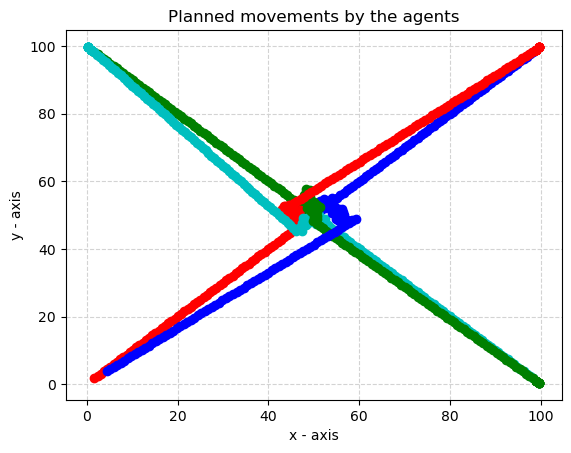

In [4]:
N = 100
speed = 1
safty_radius = 1.5
num_of_agents = 4
max_dis = 5
colors = ['r', 'b', 'g', 'c']

init_locations = [[1, 1], [N - 1, N - 1], [1, N - 1], [N - 1, 1]]
goal_locations = [[N - 1, N - 1], [1, 1], [N - 1, 1], [1, N - 1]]

min_distances_plan, KFilters, actions, added_time_tot = genoratePlannedPath(
        init_locations[0: num_of_agents], goal_locations[0: num_of_agents],
        num_of_agents, max_dis, speed, colors[0: num_of_agents], N, safty_radius)

plt.show()

We can measure how near the agent was to the designated safety radius once the plan was prepared.
Along the path, the agents must avoid getting too near to the other agent so that they do not collide.

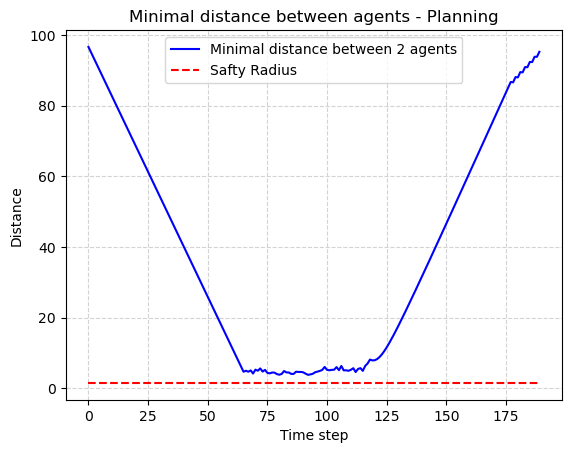

In [5]:
plotMinDistances(min_distances_plan, safty_radius)
plt.title('Minimal distance between agents - Planning')
plt.show()

Following this stage, the agents proceed from the initial location to the goal location, where their location uncertainty is incorporated. As a result, they deviate from the intended course.

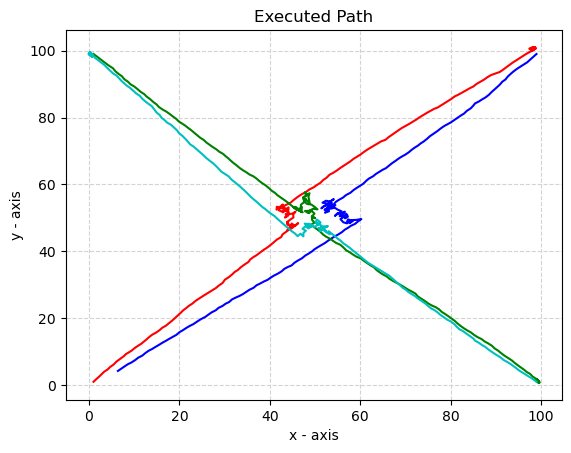

In [6]:
Locations_x = []
Locations_y = []
min_distances_exe = []

for i in range(num_of_agents):
    X = KFilters[i].runSim(actions[i])
    KFilters[i].plotTrajectory(X, colors[i])
    x_location, y_location = fromMat2LocationVal(X, len(X))
    Locations_x.append(x_location)
    Locations_y.append(y_location)

plt.show()

Using the actual path that was taken, we can observe the shortest distance between two agents along the path once more.

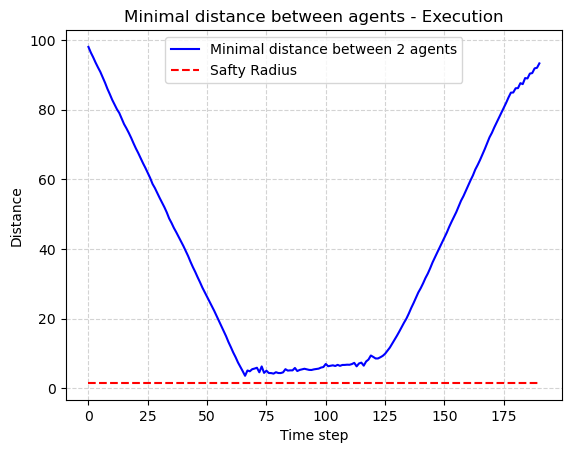

In [7]:
for i in range(len(Locations_x[0])):
    curr_locations = []
    for j in range(num_of_agents):
        curr_locations.append([Locations_x[j][i], Locations_y[j][i]])
    min_distances_exe.append(minDistanceBetweenAllAgents(curr_locations))

plotMinDistances(min_distances_exe, safty_radius)
plt.title('Minimal distance between agents - Execution')
plt.show()

## Evaluation

I looked at two factors in my evaluation:

1. The shortest distance between the agents along the path. This was done to ensure that the new algorithm remains valid and does not lead the agents to become too close to each other.

1. The relative amount of extra time steps required to avoid accidents with various numbers of agents switching positions. This was done to examine how much more time is added as a result of the stalemate solution.


## Results

First, when I looked at the safety radius maintained between the agents, I anticipated it to be the same as in the original study. Though I expected the location uncertainty to be a bigger issue in terms of avoiding out from the safety radius, it was minor to non-existent.
In general, the results are similar to those of the original work, with outliers as shown in the figures below, and the path execution being inferior than the intended path in terms of safety duration but still helpful.

<img src="images\min_distance_planning.png" width="500" align="center"/>
<img src="images\min_distance_execution.png" width="500" align="center"/>

I expected it to occupy a big amount of the time when I looked at the extra time steps when random actions were conducted. Although I did not expect the percentage to be as high as 50% for only 8 agents.

<img src="images\Relative added time due to random steps.png" width="500" align="center"/>



## Method Limitations / Possible Future Extensions

The proposed technique **improves** on the original method by preventing deadlock while still ensuring the safety radius between the agents.
    
The suggested technique includes **flaws**, such as the comparatively large number of time steps required for collision avoidance even with a small number of agents, as seen in the result section. Another flaw is the fact that there are no guaranties on runtime due to the nature of a random step.
    
In future study, a mix of the two approaches can be developed such that the random actions are only done if the deadlock persists.

# References



[1] [B-UAVC: Buffered Uncertainty-Aware Voronoi Cells for Probabilistic Multi-Robot Collision Avoidance](https://ieeexplore.ieee.org/document/8901092)

[2] [Fast, On-line Collision Avoidance for Dynamic Vehicles Using Buffered Voronoi Cells](https://ieeexplore.ieee.org/abstract/document/7828016)